# Running the CAS Networks 
This notebook shows how to load and prep your data before running the trained networks. 
You can create a suitable conda enviroment to run this notebook using:

```
conda create -n casnet_demo python=3 tensorflow matplotlib ipykernel pandas seaborn
```

### Common imports 

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# better-looking plots
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['font.size'] = 14

In [3]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

### Set up TensorFlow in a friendly manner

In [4]:
import tensorflow as tf

# if multiple GPUs, only use one of them 
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"


# avoid hogging all the GPU memory
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.compat.v1.Session(config=config)

### Import Keras modules needed to load the models 

In [5]:
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential, load_model

### Load the Concentration and Asymmetry models 

In [6]:
#Functions needed to load CNN model
#RMSE     
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))  
    
def pearson_r(y_true, y_pred):
    x = y_true
    y = y_pred
    mx = K.mean(x, axis=0)
    my = K.mean(y, axis=0)
    xm, ym = x - mx, y - my
    r_num = K.sum(xm * ym)
    x_square_sum = K.sum(xm * xm)
    y_square_sum = K.sum(ym * ym)
    r_den = K.sqrt(x_square_sum * y_square_sum)
    r = r_num / r_den
    return K.mean(r)

path = '/Users/cbtohill/Documents/PhD/CASNET/'

#Concentration network
C_model = load_model(path + str('C_weights.hdf5'),
                        custom_objects={'root_mean_squared_error': root_mean_squared_error, 'pearson_r':pearson_r})

#Asymmetry network 
A_model = load_model(path + str('A_weights.hdf5'),
                        custom_objects={'root_mean_squared_error': root_mean_squared_error, 'pearson_r':pearson_r})

### Load images to test 

In [7]:
test_imgs = np.load(path+str('testing_imgs.npy'))
print(test_imgs.shape)

(622, 60, 60)


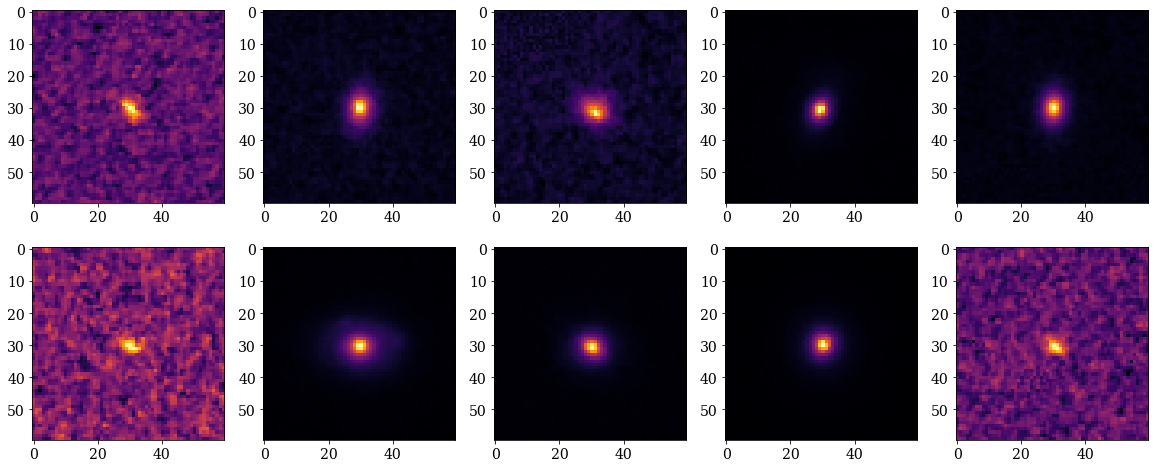

In [8]:
plt.figure(figsize=(20, 8))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(test_imgs[i], cmap='inferno')
plt.show()

### Prepare the data

In [9]:
#Normalise so max pixel is 1 and reshape data for input to network 
norm_imgs = []
for image in test_imgs:
    norm  = image/np.max(image)
    norm_imgs.append(norm)

norm_imgs = np.array(norm_imgs)
norm_imgs = np.expand_dims(norm_imgs, axis = 3)

In [10]:
norm_imgs.shape

(622, 60, 60, 1)

### Make predictions 

In [11]:
C_preds = C_model.predict(norm_imgs)
A_preds = A_model.predict(norm_imgs)

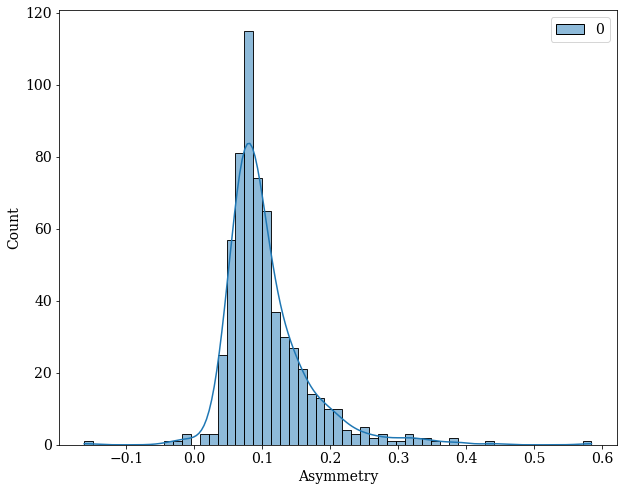

In [18]:
sns.histplot(A_preds, kde= True)
plt.xlabel('Asymmetry')
plt.show()

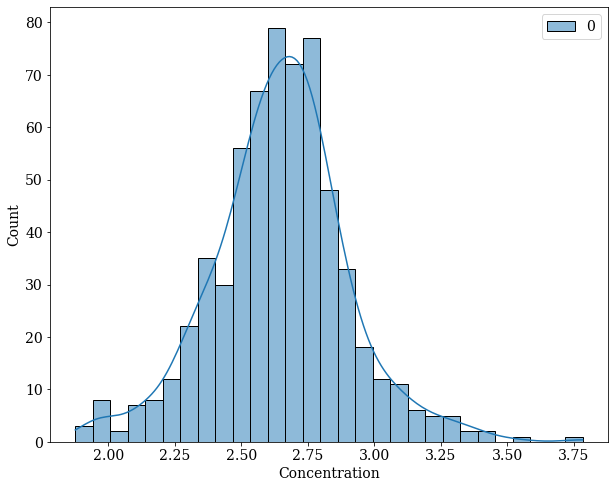

In [22]:
sns.histplot(C_preds, kde = True)
plt.xlabel('Concentration')
plt.show()